# Выбор локации для скважины

# Описание проекта
Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль.

In [1]:
!pip install phik
!pip install scikit-learn --upgrade

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import phik
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from scipy import stats as st

sns.set(rc={'figure.figsize':(10,7)})

## Загрузка и подготовка данных

In [3]:
# выгрузим данные
geo_1 = pd.read_csv('/datasets/geo_data_0.csv') 

In [4]:
geo_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
# выгрузим данные
geo_2 = pd.read_csv('/datasets/geo_data_1.csv') 

In [6]:
geo_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
# выгрузим данные
geo_3 = pd.read_csv('/datasets/geo_data_2.csv') 

In [8]:
geo_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
# проверим на наличие пропусков и дубликатов
# создадим функцию для просмотра основной информации, проверки на наличие пропусков и дубликатов
def pred(data):
    print(data.info())
    print('\n')
    print('Количество пропусков:')
    print(data.isna().sum())
    print('\n')
    print(f'Количество дубликатов: {data.duplicated().sum()}')

In [10]:
# применим функцию на наших данных
pred(geo_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Количество пропусков:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество дубликатов: 0


In [11]:
pred(geo_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Количество пропусков:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество дубликатов: 0


In [12]:
pred(geo_3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Количество пропусков:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество дубликатов: 0


In [13]:
# проверим данные на количество дубликатов
geo_1['id'].duplicated().sum()

10

In [14]:
geo_2['id'].duplicated().sum()

4

In [15]:
geo_3['id'].duplicated().sum()

4

In [16]:
# проведём исследовательский анализ данных
# создадим функцию для построения boxplot (для количественных переменные)
def graph_box(data):
    for i in data.columns:
        data.boxplot(column=i, figsize=(8,8))
        plt.title(f'График распределения значение столбца {i}')
        plt.show()
        
# создадим функцию для построения гистограмм (также количественные переменные)
def graph_hist(data):
    for i in data.columns.unique():
        if i == 'salary' or i == 'job_satisfaction_rate':
            fig, ax = plt.subplots(figsize=(12, 12))
            plt.hist(data[i])
            plt.title(f'Гистограмма распределений для столбца {i}')
            plt.xlabel(f'{i}')
            plt.ylabel('Количество сотрудников')
            plt.show()
            
# создадим функцию для количественных переменных
def graph_num(data):
    graph_box(data)
    graph_hist(data)

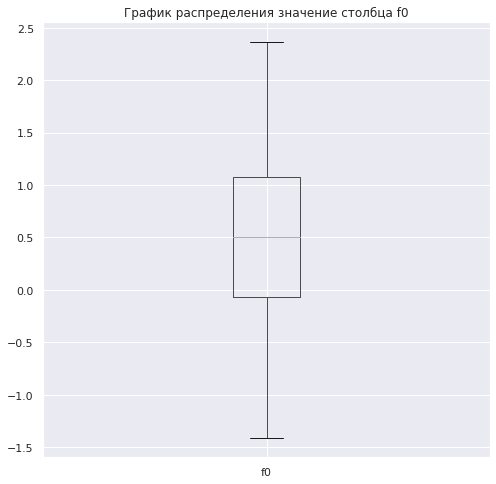

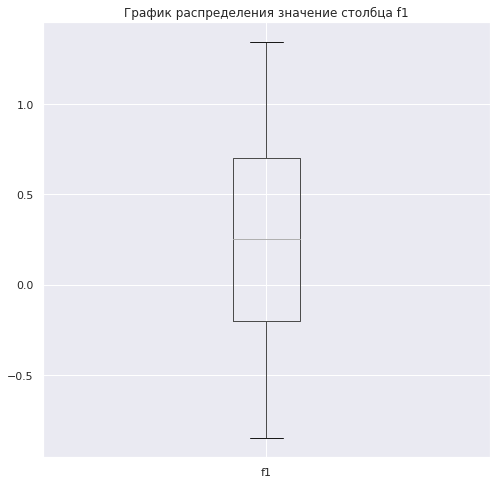

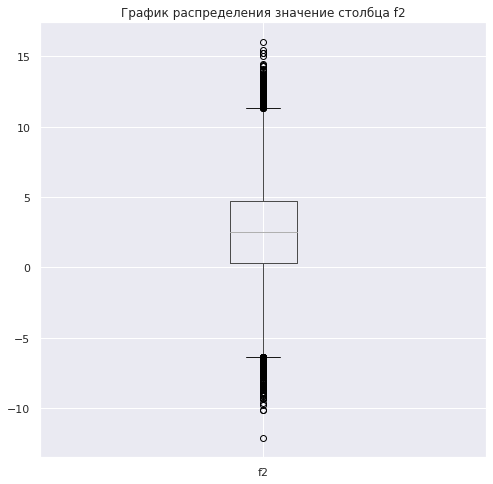

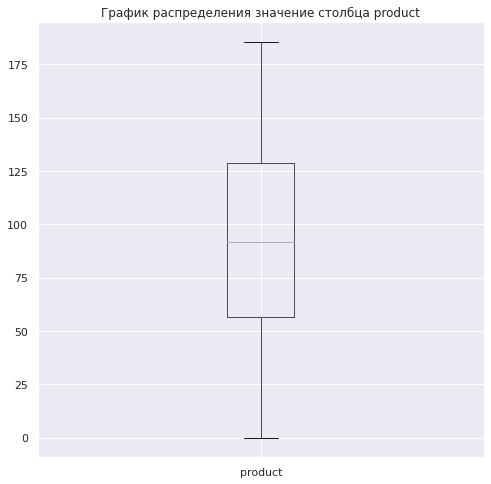

In [17]:
# строим графики
graph_num(geo_1.drop('id', axis=1))

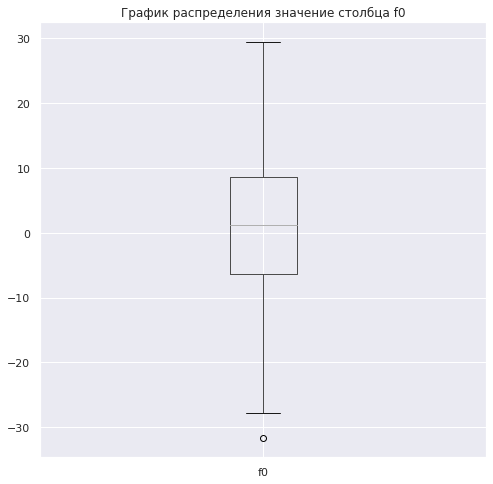

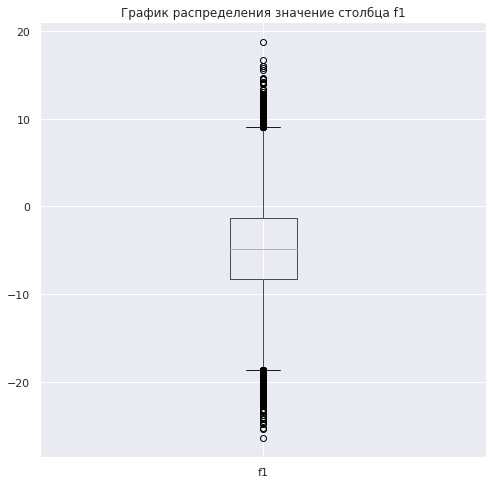

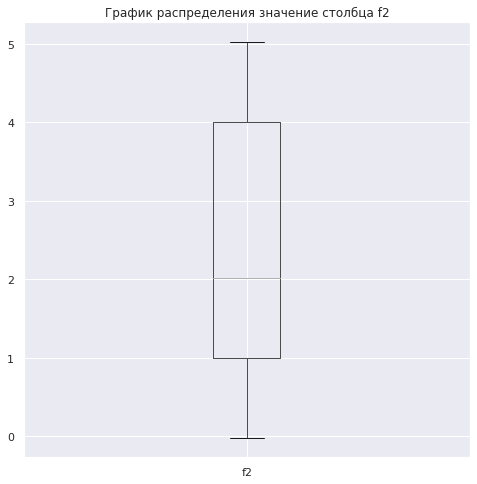

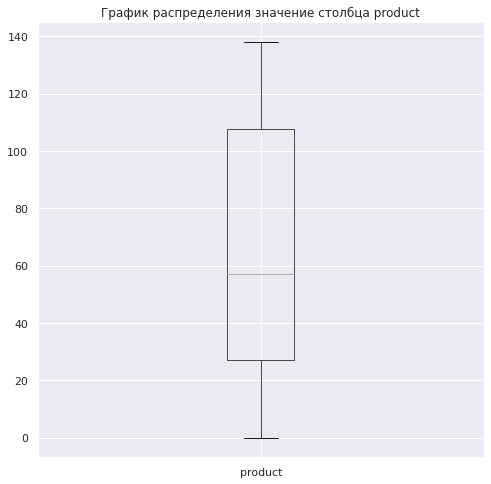

In [18]:
graph_num(geo_2.drop('id', axis=1))

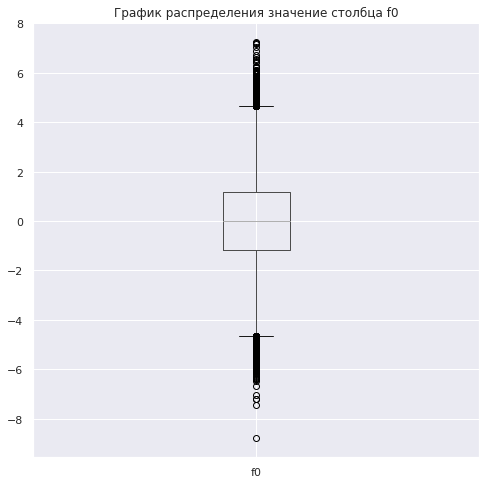

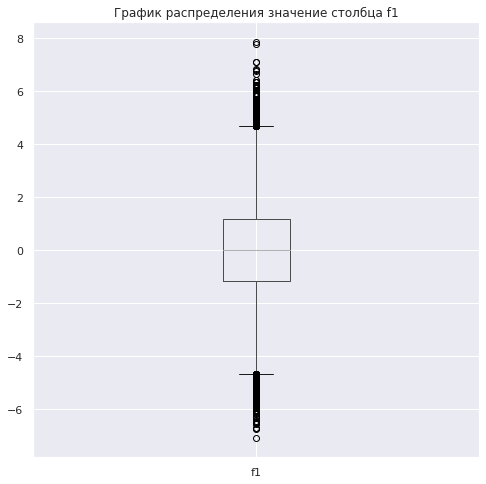

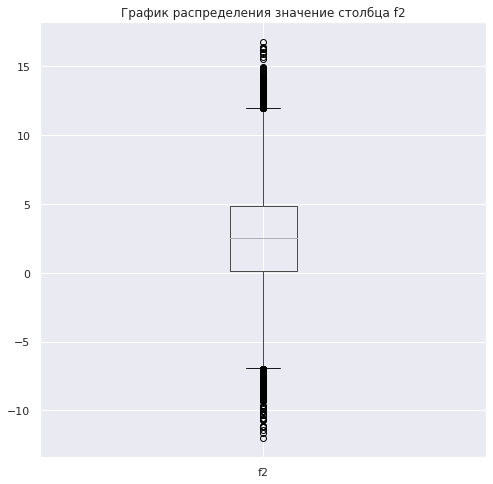

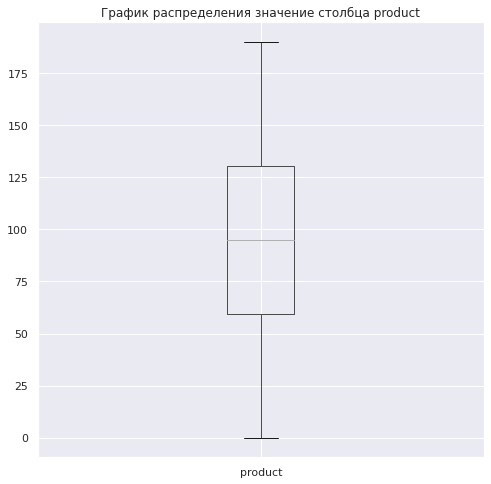

In [19]:
graph_num(geo_3.drop('id', axis=1))

In [20]:
# проведём корреляционный анализ
# выведем корреляционную матрицу для первого региона
geo_1.drop('id', axis=1).corr() 

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


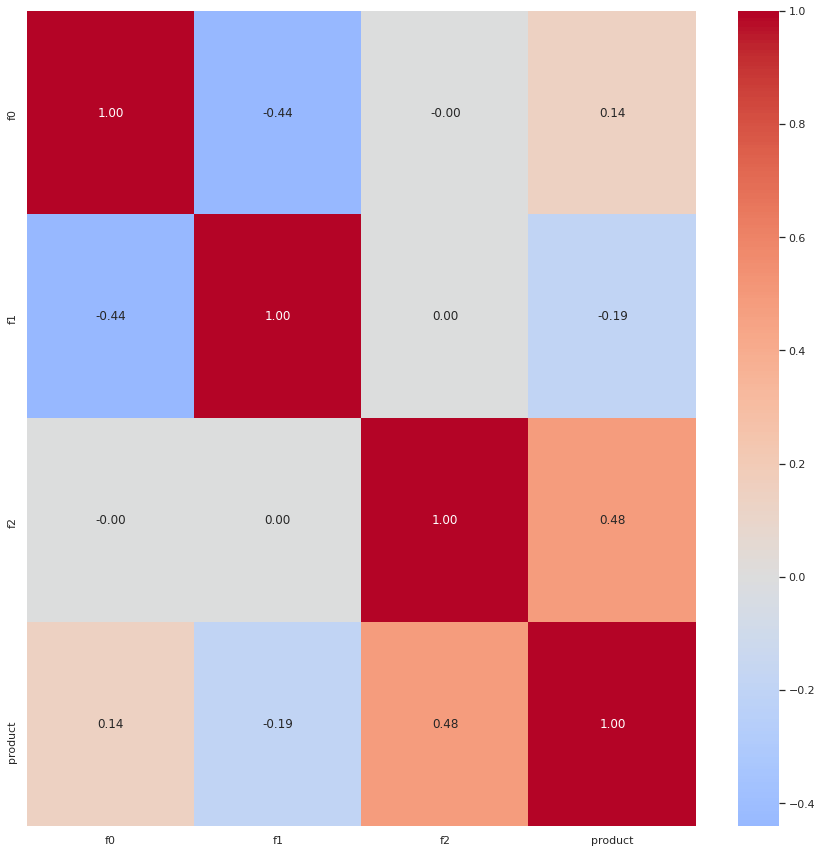

In [21]:
# для наглядности построим тепловую карту
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(geo_1.drop('id', axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0); 

In [22]:
# выведем корреляционную матрицу для второго региона
geo_2.drop('id', axis=1).corr() 

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


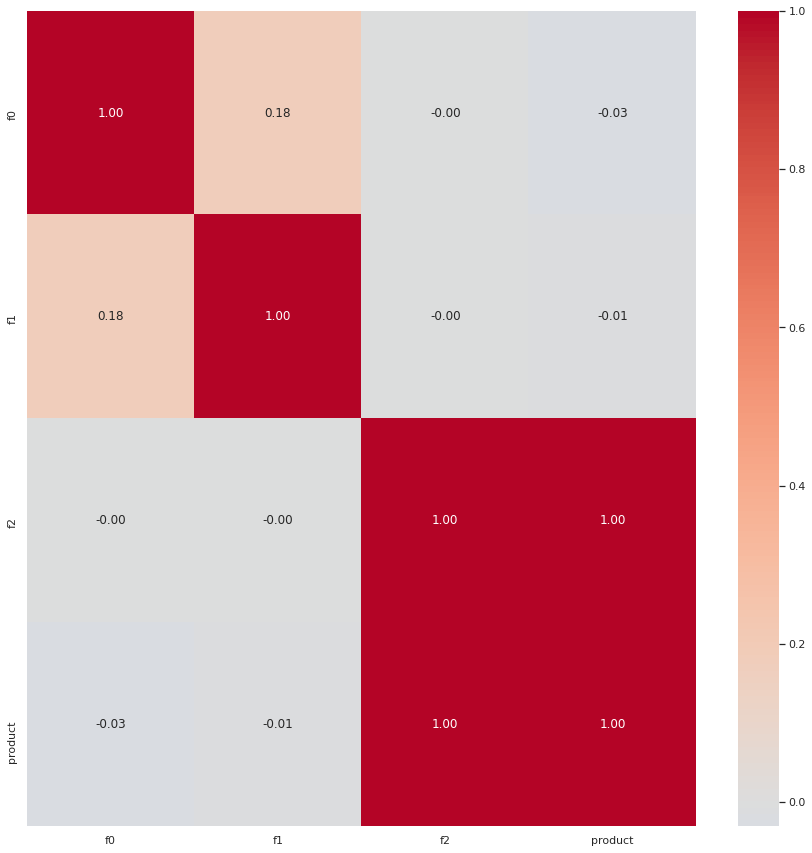

In [23]:
# для наглядности построим тепловую карту
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(geo_2.drop('id', axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0); 

In [24]:
# выведем корреляционную матрицу для третьего региона
geo_3.drop('id', axis=1).corr() 

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


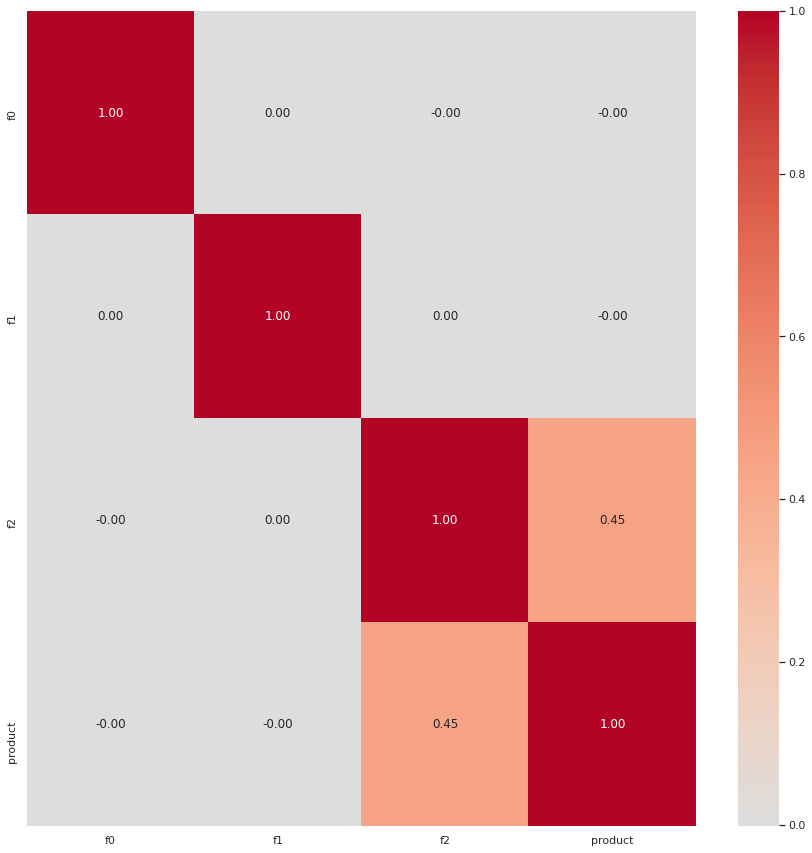

In [25]:
# для наглядности построим тепловую карту
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(geo_3.drop('id', axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0); 

### Вывод
- Данные загружены и не требуют дополнительной предобработки
- Выбросов, аномальных значений не обнаружено
- Сильнее всего целевой признак коррелирует с признаком f2 (во всех регионах)

## Обучение и проверка модели

In [26]:
# зафиксируем константы
RANDOM_STATE = 42
test_size = 0.25

In [27]:
# разделим данные на тренировочный и валидационные для первого региона 
X = geo_1.drop(['product', 'id'], axis=1)
y = geo_1['product']

In [28]:
# делим данные
X_train, X_valid, y_train, y_valid_1 = train_test_split(X, y, random_state=RANDOM_STATE, test_size=test_size)

In [29]:
# нормируем данные
scaler = StandardScaler()
X_train_scaled = scaler. fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

X_train_1 = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_1 = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)

In [30]:
# создадим модель МО
model_1  = LinearRegression()

# обучим её
model_1.fit(X_train_1, y_train)

# получим предсказания на валидационной выборке
predictions_1 = model_1.predict(X_valid_1)

In [31]:
pred_1 = pd.DataFrame(predictions_1, columns = ['product_pred_1'])

In [32]:
pred_1.head()

,product_pred_1
0,101.901017
1,78.217774
2,115.266901
3,105.618618
4,97.980185


In [33]:
print('Средний запас предсказанного сырья равен', pred_1['product_pred_1'].mean())

Средний запас предсказанного сырья равен 92.39879990657768


In [34]:
rmse_1 = mean_squared_error(y_valid_1, predictions_1, squared=False)

print('RMSE равно', rmse_1)

RMSE равно 37.75660035026169


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
# то же самое сделаем и для второго региона
# разделим данные на тренировочный и валидационные для второго региона 
X = geo_2.drop(['product', 'id'], axis=1)
y = geo_2['product']

In [36]:
X_train, X_valid, y_train, y_valid_2 = train_test_split(X, y, random_state=RANDOM_STATE, test_size=test_size)

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler. fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

X_train_2 = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_2 = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)

In [38]:
# создадим модель МО
model_2  = LinearRegression()

# обучим её
model_2.fit(X_train_2, y_train)

# получим предсказания на валидационной выборке
predictions_2 = model_2.predict(X_valid_2)

In [39]:
pred_2 = pd.DataFrame(predictions_2, columns = ['product_pred_2'])

In [40]:
pred_2.head()

,product_pred_2
0,0.844738
1,52.921612
2,135.110385
3,109.494863
4,-0.047292


In [41]:
print('Средний запас предсказанного сырья равен', pred_2['product_pred_2'].mean())

Средний запас предсказанного сырья равен 68.7128780391376


In [42]:
rmse_2 = mean_squared_error(y_valid_2, predictions_2, squared=False)

print('RMSE равно', rmse_2)

RMSE равно 0.8902801001028846


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
# и для третьего
# разделим данные на тренировочный и валидационные для третьего региона 
X = geo_3.drop(['product', 'id'], axis=1)
y = geo_3['product']

In [44]:
X_train, X_valid, y_train, y_valid_3 = train_test_split(X, y, random_state=RANDOM_STATE, test_size=test_size)

In [45]:
scaler = StandardScaler()
X_train_scaled = scaler. fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

X_train_3 = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_3 = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)

In [46]:
# создадим модель МО
model_3  = LinearRegression()

# обучим её
model_3.fit(X_train_3, y_train)

# получим предсказания на валидационной выборке
predictions_3 = model_3.predict(X_valid_3)

In [47]:
pred_3 = pd.DataFrame(predictions_3, columns = ['product_pred_3'])

In [48]:
pred_3.head()

,product_pred_3
0,98.301916
1,101.592461
2,52.449099
3,109.922127
4,72.411847


In [49]:
print('Средний запас предсказанного сырья равен', pred_3['product_pred_3'].mean())

Средний запас предсказанного сырья равен 94.77102387765939


In [50]:
rmse_3 = mean_squared_error(y_valid_3, predictions_3, squared=False)

print('RMSE равно', rmse_3)

RMSE равно 40.145872311342174


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
# предсказания и правильные ответы
print('1 регион:\n- предсказания модели: "pred_1"\n- правильные ответы: "y_valid_1"')
print()
print('2 регион:\n- предсказания модели: "pred_2"\n- правильные ответы: "y_valid_2"')
print()
print('3 регион:\n- предсказания модели: "pred_3"\n- правильные ответы: "y_valid_3"')

1 регион:
- предсказания модели: "pred_1"
- правильные ответы: "y_valid_1"

2 регион:
- предсказания модели: "pred_2"
- правильные ответы: "y_valid_2"

3 регион:
- предсказания модели: "pred_3"
- правильные ответы: "y_valid_3"


### Вывод
- Были построены модели для предсказания целевого признака для каждого региона
- Также был предсказан средний запас предсказанного сырья и рассчитана RMSE
- Наилучший показатель RMSE у 2-го региона - 0.89
- Наибольший средний запас предсказанного сырья у 3 региона - 94.7

### Вывод

## Подготовка к расчёту прибыли

In [52]:
# зафиксируем константы
PRICE_ONE_PIECE = 450 # тыс рублей за 1 тыс баррелей

PRICE_NEW_WELL = 10_000_000 # тыс рублей на разработку новых скважин

PROBABILITY_LOSSES = 2.5/100 # вероятность убытков

product_mean_1 = geo_1['product'].mean()
product_mean_2 = geo_2['product'].mean()
product_mean_3 = geo_3['product'].mean()

In [53]:
print('Cредний запас сырья в 1 регионе: %.2f млн.баррелей'%product_mean_1)
print('Cредний запас сырья в 2 регионе: %.2f млн.баррелей'%product_mean_2)
print('Cредний запас сырья в 3 регионе: %.2f млн.баррелей'%product_mean_3)

Cредний запас сырья в 1 регионе: 92.50 млн.баррелей
Cредний запас сырья в 2 регионе: 68.83 млн.баррелей
Cредний запас сырья в 3 регионе: 95.00 млн.баррелей


In [54]:
budget_1_point = (PRICE_NEW_WELL / 200)# тыс.руб
print('Бюджет на разработку одной скважины:', budget_1_point/1000,'млн.руб')

Бюджет на разработку одной скважины: 50.0 млн.руб


In [55]:
# рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
vol_prod = budget_1_point / PRICE_ONE_PIECE
print('Объём каждой скважины для безубыточной разработки должен составлять не менее: %.2f'%vol_prod,'тыс.баррелей')

Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей


In [56]:
# сравним полученный объём сырья со средним запасом в каждом регионе

# 1 регион
geo_1['profit'] = (geo_1['product'] * (PRICE_ONE_PIECE)).round(2) # profit, тыс.руб
geo_1.head()

,id,f0,f1,f2,product,profit
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49


In [57]:
# определим ROI (окупаемость)
geo_1['roi_%'] = ((geo_1['profit'] - budget_1_point) / budget_1_point * 100).round(2)
geo_1.head()

,id,f0,f1,f2,product,profit,roi_%
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03,-5.25
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99,-34.27
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54,-23.26
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35,51.76
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49,38.63


In [58]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: {:.2%}'.format(product_mean_1 / vol_prod-1))
print('Или {:.2f} тыс.баррелей'.format(vol_prod - product_mean_1))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: -16.75%
Или 18.61 тыс.баррелей


In [59]:
# 2 регион
geo_2['profit'] = (geo_2['product'] * (PRICE_ONE_PIECE)).round(2) # profit, тыс.руб
geo_2.head()

,id,f0,f1,f2,product,profit
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430.60
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128.97
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644.84
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075.43
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644.84


In [60]:
# определим ROI (окупаемость)
geo_2['roi_%'] = ((geo_2['profit'] - budget_1_point) / budget_1_point * 100).round(2)
geo_2.head()

,id,f0,f1,f2,product,profit,roi_%
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-97.14
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128.97,-75.74
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644.84,21.29
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075.43,24.15
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644.84,21.29


In [61]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 2 региону составляет: {:.2%}'.format(product_mean_2 / vol_prod-1))
print('Или {:.2f} тыс.баррелей'.format(vol_prod - product_mean_2))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 2 региону составляет: -38.06%
Или 42.29 тыс.баррелей


In [62]:
# 3 регион
geo_3['profit'] = (geo_3['product'] * (PRICE_ONE_PIECE)).round(2) # profit, тыс.руб
geo_3.head()

,id,f0,f1,f2,product,profit
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,12491.40
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,25231.36
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,28292.36
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,51557.78
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,67320.34


In [63]:
# определим ROI (окупаемость)
geo_3['roi_%'] = ((geo_3['profit'] - budget_1_point) / budget_1_point * 100).round(2)
geo_3.head()

,id,f0,f1,f2,product,profit,roi_%
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-75.02
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,25231.36,-49.54
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,28292.36,-43.42
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,51557.78,3.12
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,67320.34,34.64


In [64]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 3 региону составляет: {:.2%}'.format(product_mean_3 / vol_prod-1))
print('Или {:.2f} тыс.баррелей'.format(vol_prod - product_mean_3))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 3 региону составляет: -14.50%
Или 16.11 тыс.баррелей


In [65]:
# создадим функция для подсчета прибыли
def profit_for_vp(predict,col,count):
    pred_sorted = predict.sort_values(by=col ,ascending=False)
    selected_max = pred_sorted[:count].sum()
    profit_pred=(selected_max*PRICE_ONE_PIECE) - PRICE_NEW_WELL 
    print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max)
    print('Прибыль для полученного объёма сырья составит %.2f млн.рублей'%(profit_pred/1000))

In [66]:
# профит 1 региона
profit_for_vp(pred_1,['product_pred_1'],200)

Суммарный запас сырья в 200 лучших скважинах составит: 30881.46 тыс.баррелей
Прибыль для полученного объёма сырья составит 3896.66 млн.рублей


In [67]:
# профит 2 региона
profit_for_vp(pred_2,['product_pred_2'],200)

Суммарный запас сырья в 200 лучших скважинах составит: 27748.75 тыс.баррелей
Прибыль для полученного объёма сырья составит 2486.94 млн.рублей


In [68]:
# профит 1 региона
profit_for_vp(pred_3,['product_pred_3'],200)

Суммарный запас сырья в 200 лучших скважинах составит: 29728.85 тыс.баррелей
Прибыль для полученного объёма сырья составит 3377.98 млн.рублей


### Вывод
- Судя по рассчётам, все три региона достаточно прибыльные
- Необходим подсчитать вероятность риска убыточного вложения

## Расчёт прибыли и рисков 

In [69]:
# применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

def profit_for_vp2(predict,target,count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * PRICE_ONE_PIECE 
    return revenue - PRICE_NEW_WELL


def bootstap(target,predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_for_vp2(probs_subsample,target_subsample, 200))  
        
    for i in values:
        if i < 0:
            count +=1
            
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, млрд.руб')
    plt.ylabel('Количество')
    plt.show()
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((low_95/1000),(high_95/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(count/1000))

  0%|          | 0/1000 [00:00<?, ?it/s]

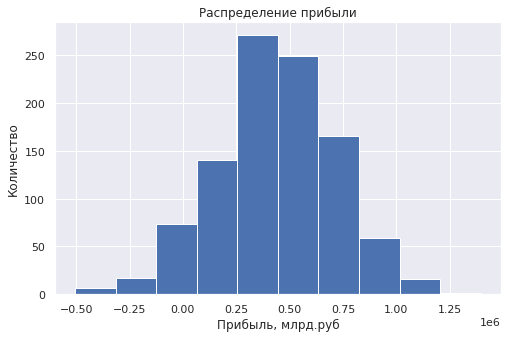

Средняя прибыль: 435.93 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -116.23 млн.руб до: 966.50 млн.руб
95%-ый доверительный интервал: от 418.76 млн.руб до 453.11 млн.руб
Процент вероятности убытка в данном регионе составит 6.1%


In [70]:
# распределение прибыли 1 региона
bootstap(y_valid_1,predictions_1)

  0%|          | 0/1000 [00:00<?, ?it/s]

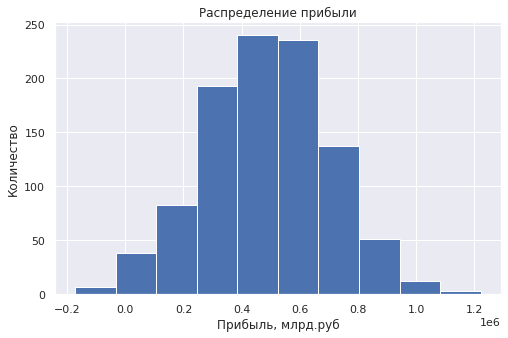

Средняя прибыль: 489.66 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 55.12 млн.руб до: 905.76 млн.руб
95%-ый доверительный интервал: от 476.23 млн.руб до 503.09 млн.руб
Процент вероятности убытка в данном регионе составит 1.1%


In [71]:
# распределение прибыли 2 региона
bootstap(y_valid_2,predictions_2)

  0%|          | 0/1000 [00:00<?, ?it/s]

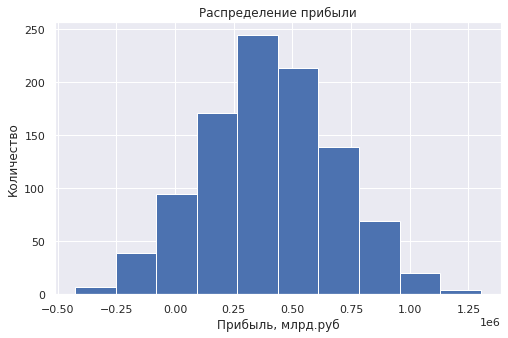

Средняя прибыль: 403.69 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -153.12 млн.руб до: 952.89 млн.руб
95%-ый доверительный интервал: от 386.21 млн.руб до 421.17 млн.руб
Процент вероятности убытка в данном регионе составит 7.1%


In [72]:
# распределение прибыли 3 региона
bootstap(y_valid_3,predictions_3)

### Вывод
- Самым прибыльным оказался 2 регион, остальные два региона имеют процент убытка больше 2,5%
- Средняя прибыль в этом регионе составит 489.66 млн рублей
- 95% доверительный интервал для прибыли находится в диапазоне от 476.23 млн.руб до 503.09 млн.руб

## Заключение
- Были исследованы данные по запасах нефти в трёх регионах
- Были обучены модели для подсчета запасов сырья в каждой скважине в каждом регионе
- Далее при помощи техники bootstap предсказанния были разделены на 1000 выборок и подсчитан риск убытка 
- В результате был определён доверительный интревал получения прибыли в 95%, ограничив вероятность убытка величиной менее 2,5% 
- На основе этих данных был выбран наиболее перспективный регион для разработки скважин
- **Наиболее перпективный регион - второй**, 95% доверительный интервал для прибыли находится в диапазоне от 476.23 млн.руб до 503.09 млн.руб, а вероятность убытка равна 1.1%